In [1]:
import asyncio
import itertools
import logging
import random
import nest_asyncio

nest_asyncio.apply()  # must be run at the start of every notebook to patch the event loop to allow nesting, eg. so we can run asyncio.run from within a notebook.

In [2]:
import torch

torch.cuda.is_available()

True

In [3]:
import os
from pathlib import Path
import tempfile

from shutil import rmtree
from typing import List, Optional, Union

In [4]:
# Adjust your env variables here if nescesary

%env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
%env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
%env NUPLAN_EXP_ROOT=../../data/nuplan/exp
%env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
%pwd

env: NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
env: NUPLAN_MAPS_ROOT=../../data/nuplan/maps
env: NUPLAN_EXP_ROOT=../../data/nuplan/exp
env: NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/


'/home/ehdykhne/nuplan-devkit/experiments'

In [5]:
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path
from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)
from nuplan.planning.script.utils import (
    run_runners,
    set_default_path,
    set_up_common_builder,
)
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = os.getenv("NUPLAN_HYDRA_CONFIG_PATH", "config/simulation")

if os.environ.get("NUPLAN_HYDRA_CONFIG_PATH") is not None:
    CONFIG_PATH = os.path.join("../../../../", CONFIG_PATH)

if os.path.basename(CONFIG_PATH) != "simulation":
    CONFIG_PATH = os.path.join(CONFIG_PATH, "simulation")
CONFIG_NAME = "default_simulation"

In [6]:
# list of selected scenario tokens
from tokens import selected_scenario_tokens, modifiable_scenario_tokens

print(selected_scenario_tokens[0:3])
print(modifiable_scenario_tokens[0:3])

selected_scenario_tokens = ["fa01caf734875df7"]

['d6234553edc95d50', '98ddd7851e445b7a', '5ac5795b9b5851e8']
['014c7f3502d4597d', '02828821ef045829', '02fa9b8d43465e0d']


In [7]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(
    os.getenv("NUPLAN_TUTORIAL_PATH", ""), "../nuplan/planning/script"
)
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

# Create a temporary directory to store the simulation artifacts

left_turn_types = [
    "stopping_at_crosswalk",
    "high_lateral_acceleration",
    "near_multiple_vehicles",
    "on_stopline_stop_sign",
    "near_long_vehicle",
    "unknown",
    "near_barrier_on_driveable",
    "near_high_speed_vehicle",
]
scenario_types = [
    # "accelerating_at_traffic_light_with_lead",
    # "crossed_by_bike",
    # "crossed_by_vehicle",
    # "on_intersection",
    # "on_stopline_crosswalk",
    # "on_stopline_stop_sign",
    # "on_stopline_traffic_light",
    # "on_traffic_light_intersection",
    # "starting_protected_cross_turn",
    # "starting_protected_noncross_turn",
    # "starting_right_turn",
    "starting_straight_stop_sign_intersection_traversal",
    "starting_straight_traffic_light_intersection_traversal",
    # "starting_u_turn",
    "starting_unprotected_cross_turn",
    # "starting_unprotected_noncross_turn",
    # "stationary_at_crosswalk",
    # "stationary_at_traffic_light_with_lead",
    # "stationary_at_traffic_light_without_lead",
    "traversing_crosswalk",
    "traversing_intersection",
    "traversing_traffic_light_intersection",
]

# scenario_types = ['stationary_at_traffic_light_without_lead']

scenario_builder = "val"  # [nuplan (uses trainval), nuplan_mini, test, val, train_boston, train_pittsburgh, train_singapore]
DATASET_PARAMS = [
    f"scenario_builder={scenario_builder}",
    "scenario_filter=all_scenarios",  # [all_scenarios, val14_split]
    # f"scenario_filter.scenario_types={left_turn_types}",  # there are 70 scenario types in the trainingset and 58 in the validation set including "unknown" which make up the majority
    "scenario_filter.ego_displacement_minimum_m=10",  # use scenarios where the ego vehicle moves at least 10m
    #    'scenario_filter.remove_invalid_goals=true',  # remove scenarios where the goal is not invalid
    "scenario_filter.ego_start_speed_threshold=5",  # Exclusive threshold that the ego's speed must rise above (meters per second) for scenario to be kept
    #    'scenario_filter.stop_speed_threshold=10',  # Inclusive threshold that the ego's speed must fall below (meters per second) for scenario to be kept:
    "scenario_filter.map_names=[sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood]",  # select multiple [sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]
    # "scenario_filter.num_scenarios_per_type=300",  # use 10 scenarios per scenario type
    # f"scenario_filter.scenario_tokens={selected_scenario_tokens}",  # List of scenarios to include (token)
    #'scenario_filter.log_names=["2021.08.24.20.03.01_veh-45_01091_01622"]',  # specific scenrios to simulate
    "scenario_filter.limit_total_scenarios=0.05",  # use n total scenarios if int, or if float smaller than 1, use n as a fraction of total scenarios (changes sampling frequency, unchanged leaves the frequency at 20Hz)
    # turn off if you are selecting scenarios manually. turn on for initial filtering (0.05 gives us 1 scenario per second)
]
urban_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt"
gc_pgp_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/gc_pgp_checkpoint.ckpt"
hybrid_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/pdm_offset_checkpoint.ckpt"
#'/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
#'/home/ehdykhne/Repos/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
print(simulation_hydra_paths.config_name)
cfg = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        "+simulation=open_loop_boxes",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
        "planner=log_future_planner",  # [ml_planner, pdm_hybrid_planner, gc_pgp_planner, idm_planner, log_future_planner, simple_planner]
        "ego_controller=perfect_tracking_controller",
        "worker=ray_distributed",  # [sequential, ray_distributed]
        "+occlusion=false",  # [true, false]
        # "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
        # "+occlusion.uncloak_reaction_time=1.5",
        # "+occlusion.notice_threshold=1.0",
        # "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
    ],
)

output_folder = cfg.output_dir
print('output_folder = "' + output_folder + '"')


# closed mixed for simulation
# "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
# "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
# # "model=gc_pgp_model",
# # "model.aggregator.pre_train=false",
# # "planner.ml_planner.model_config=${model}",
# # f"planner.ml_planner.checkpoint_path={gc_pgp_ckpt}",
# # f"planner.pdm_closed_planner.checkpoint_path={hybrid_ckpt}",
# # "+observation.model=gc_pgp_model",
# # "+observation.model.aggregator.pre_train=false",
# # "+observation.model_config=${model}",
# # f"+observation.checkpoint_path={gc_pgp_ckpt}",
# f"observation.planner_type=pdm_closed",
# # # f"observation.pdm_hybrid_ckpt={hybrid_ckpt}",
# f"observation.occlusion_cfg.occlusion=true",
# f"observation.occlusion_cfg.manager_type=wedge",
# f"+observation.occlusion_cfg.uncloak_reaction_time=1.5",
# f"+observation.occlusion_cfg.notice_threshold=1.0",
# "+modify_scenario_simulations=true",
# "+modifier_types=[occlusion-injection]",  # can select multiple: [occlusion-injection, left-and-right]
# "+occlusion=true",
# "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
# "+occlusion.uncloak_reaction_time=1.0",
# "+occlusion.notice_threshold=0.1",
# "worker=ray_distributed",  # [sequential, ray_distributed]
# "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
# *DATASET_PARAMS,

# openloop config for finding risky scenarios
# "+simulation=open_loop_boxes",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
#         "planner=log_future_planner",  # [ml_planner, pdm_hybrid_planner, gc_pgp_planner, idm_planner, log_future_planner, simple_planner]
#         "ego_controller=perfect_tracking_controller",
#         "worker=ray_distributed",  # [sequential, ray_distributed]
#         "+occlusion=true",  # [true, false]
#         "+occlusion.manager_type=wedge",  # options: [range, shadow, wedge]
#         "+occlusion.uncloak_reaction_time=1.5",
#         "+occlusion.notice_threshold=1.0",
#         # "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
#         *DATASET_PARAMS,


# output folders for runs:
# closed_loop_reactive_agents, wedge occlusions, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.21.59.48"
# overall score: 0.5041, ego_at_fault_collisions: 363

# closed_loop_reactive_agents, occlusions = False, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.23.21.13"
# overall score: 0.5041, ego_at_fault_collisions: 357

# closed_loop_nonreactive_agents, occlusions = False, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.02.01.14"
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.07.32.41"
# overall score: , ego_at_fault_collisions:

# closed_loop_nonreactive_agents, wedge occlusions, urban_planner
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.08.29.23"
# overall score: , ego_at_fault_collisions:

# closed_loop_reactive_agents, wedge occlusions, gc_pgp
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.10.09.31.44"
# overall score: , ego_at_fault_collisions:

# 'closed_loop_reactive_agents, occlusions = False, gc_pgp'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.11.00.41.30"

# 'closed_loop_reactive_agents, occlusions = False, pdm_hybrid'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.12.21.28"

# 'closed_loop_reactive_agents,  wedge occlusions, pdm_hybrid'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.13.07.48"

default_simulation
output_folder = "../../data/nuplan/exp/exp/simulation/open_loop_boxes/2024.01.31.22.03.05"


# Now we can run with the following

Global seed set to 0
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2024-01-31 22:03:06,009 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-01-31 22:03:06,011 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2024-01-31 22:03:07,640	INFO worker.py:1636 -- Started a local Ray instance.


2024-01-31 22:03:08,319 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-01-31 22:03:08,320 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 4
Number of threads across all nodes: 32
2024-01-31 22:03:08,320 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2024-01-31 22:03:08,320 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2024-01-31 22:03:08,320 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: ../../data/nuplan/exp/exp/simulation/open_loop_boxes/2024.01.31.22.03.05

2024-01-31 22:03:08,322 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:7

Ray objects: 100%|██████████| 32/32 [00:02<00:00, 11.68it/s]


2024-01-31 22:05:37,236 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:82}  Building metric engines...
2024-01-31 22:05:37,304 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:84}  Building metric engines...DONE
2024-01-31 22:05:37,304 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:88}  Building simulations from 3247 scenarios...
2024-01-31 22:05:49,653 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:173}  Building simulations...DONE!
2024-01-31 22:05:49,653 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:113}  Running simulation...
2024-01-31 22:05:49,653 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:138}  Executing runners...
2024-01-31 22:05:49,653 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:82}  Starting 3247 simulations using RayDistr

Ray objects:   0%|          | 2/3247 [00:01<47:53,  1.13it/s]  

(wrapped_fn pid=1478694) f 0112b70d4cc1567d


Ray objects:   1%|          | 20/3247 [00:03<07:20,  7.32it/s]

(wrapped_fn pid=1478691) e


Ray objects:   2%|▏         | 55/3247 [00:07<04:27, 11.92it/s]

(wrapped_fn pid=1478698) f 0312e1ee75d85473 [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)


Ray objects:   3%|▎         | 109/3247 [00:15<06:58,  7.50it/s]

(wrapped_fn pid=1478704) f 0862db040c695020 [repeated 2x across cluster]


Ray objects:   5%|▌         | 173/3247 [00:23<05:39,  9.07it/s]

(wrapped_fn pid=1478685) e


Ray objects:   6%|▌         | 180/3247 [00:24<04:21, 11.75it/s]

(wrapped_fn pid=1478694) f 0e8b3178a8c15984


Ray objects:   8%|▊         | 265/3247 [00:34<04:55, 10.09it/s]

(wrapped_fn pid=1478702) e
(wrapped_fn pid=1478699) f 0f5a0cf91f115c78 [repeated 2x across cluster]


Ray objects:   9%|▉         | 307/3247 [00:39<05:13,  9.39it/s]

(wrapped_fn pid=1478680) e
(wrapped_fn pid=1478687) e


Ray objects:  12%|█▏        | 399/3247 [00:52<03:57, 12.00it/s]

(wrapped_fn pid=1478679) f 1edea873b6fd5c7b
(wrapped_fn pid=1478703) f 1edea873b6fd5c7b


Ray objects:  17%|█▋        | 542/3247 [01:10<03:42, 12.18it/s]

(wrapped_fn pid=1478683) e
(wrapped_fn pid=1478681) f 19a0a92244aa59b9 [repeated 2x across cluster]


Ray objects:  20%|█▉        | 641/3247 [01:23<04:25,  9.83it/s]

(wrapped_fn pid=1478689) e [repeated 2x across cluster]


Ray objects:  21%|██        | 678/3247 [01:27<04:39,  9.20it/s]

(wrapped_fn pid=1478698) f 327b498c44845e7a
(wrapped_fn pid=1478674) e [repeated 2x across cluster]


Ray objects:  22%|██▏       | 725/3247 [01:33<04:39,  9.03it/s]

(wrapped_fn pid=1478685) f 35efb9886b435f30 [repeated 2x across cluster]


Ray objects:  23%|██▎       | 743/3247 [01:36<05:18,  7.87it/s]

(wrapped_fn pid=1478692) e


Ray objects:  25%|██▌       | 824/3247 [01:47<05:23,  7.50it/s]

(wrapped_fn pid=1478677) f 3d15d832bf64559f


Ray objects:  26%|██▌       | 829/3247 [01:48<04:44,  8.51it/s]

(wrapped_fn pid=1478703) f 3d694cd52ed45ca9


Ray objects:  26%|██▌       | 848/3247 [01:50<04:37,  8.63it/s]

(wrapped_fn pid=1478686) e


Ray objects:  27%|██▋       | 879/3247 [01:54<05:04,  7.78it/s]

(wrapped_fn pid=1478689) f 417e8d073c975a35 [repeated 6x across cluster]


Ray objects:  28%|██▊       | 922/3247 [02:00<05:20,  7.26it/s]

(wrapped_fn pid=1478685) f 438f39653ab353c0 [repeated 3x across cluster]


Ray objects:  30%|██▉       | 965/3247 [02:06<07:19,  5.20it/s]

(wrapped_fn pid=1478683) f 47df6320a91e53a5


Ray objects:  30%|███       | 980/3247 [02:08<06:15,  6.05it/s]

(wrapped_fn pid=1478692) f 48d20b110a9e58cd


Ray objects:  31%|███       | 1013/3247 [02:12<04:55,  7.57it/s]

(wrapped_fn pid=1478682) e


Ray objects:  35%|███▍      | 1136/3247 [02:28<04:03,  8.67it/s]

(wrapped_fn pid=1478689) h [<nuplan.common.maps.nuplan_map.lane.NuPlanLane object at 0x7f4be83c49a0>]
(wrapped_fn pid=1478689) found a candidate!
(wrapped_fn pid=1478705) f 4960f5dc346f5359 [repeated 3x across cluster]


Ray objects:  36%|███▋      | 1185/3247 [02:35<05:24,  6.36it/s]

(wrapped_fn pid=1478699) e
(wrapped_fn pid=1478689) f 564aa90ba1895f5e [repeated 2x across cluster]


Ray objects:  38%|███▊      | 1223/3247 [02:40<04:24,  7.65it/s]

(wrapped_fn pid=1478691) e [repeated 2x across cluster]
(wrapped_fn pid=1478701) f 5acf55b005155487 [repeated 2x across cluster]


Ray objects:  40%|███▉      | 1283/3247 [02:48<05:49,  5.61it/s]

(wrapped_fn pid=1478691) f 5fe35911d53e5654


Ray objects:  41%|████      | 1329/3247 [02:54<06:48,  4.69it/s]

(wrapped_fn pid=1478699) e


Ray objects:  42%|████▏     | 1362/3247 [02:57<03:14,  9.69it/s]

(wrapped_fn pid=1478698) f 6592e1e58dfd533a


Ray objects:  43%|████▎     | 1383/3247 [03:00<02:24, 12.94it/s]

(wrapped_fn pid=1478683) i 6623ddc3bdf25d0c


Ray objects:  44%|████▍     | 1434/3247 [03:06<03:46,  8.01it/s]

(wrapped_fn pid=1478697) f 6b27acef125c524a [repeated 2x across cluster]


Ray objects:  44%|████▍     | 1440/3247 [03:07<03:52,  7.79it/s]

(wrapped_fn pid=1478687) e


Ray objects:  47%|████▋     | 1530/3247 [03:19<04:58,  5.76it/s]

(wrapped_fn pid=1478677) f 7376ad6b02435b26
(wrapped_fn pid=1478703) f 7376ad6b02435b26


Ray objects:  48%|████▊     | 1544/3247 [03:21<03:08,  9.01it/s]

(wrapped_fn pid=1478699) f 72c7c2f2455c55e9


Ray objects:  48%|████▊     | 1553/3247 [03:22<03:50,  7.34it/s]

(wrapped_fn pid=1478706) e


Ray objects:  50%|████▉     | 1615/3247 [03:29<03:03,  8.91it/s]

(wrapped_fn pid=1478687) h [<nuplan.common.maps.nuplan_map.lane.NuPlanLane object at 0x7fc00d314610>]
(wrapped_fn pid=1478687) i 78b317e9b7365c2a
(wrapped_fn pid=1478699) i 78b317e9b7365c2a


Ray objects:  54%|█████▍    | 1752/3247 [03:47<02:59,  8.34it/s]

(wrapped_fn pid=1478681) found a candidate!
(wrapped_fn pid=1478681) found a candidate!


Ray objects:  54%|█████▍    | 1759/3247 [03:48<04:14,  5.85it/s]

(wrapped_fn pid=1478704) h [<nuplan.common.maps.nuplan_map.lane.NuPlanLane object at 0x7fde02ad8f10>]


Ray objects:  54%|█████▍    | 1762/3247 [03:48<02:54,  8.52it/s]

(wrapped_fn pid=1478689) e
(wrapped_fn pid=1478679) f 83a18a11bf9b5baa


Ray objects:  56%|█████▌    | 1815/3247 [03:54<02:35,  9.22it/s]

(wrapped_fn pid=1478704) f 87964ca9de4c5b2a
(wrapped_fn pid=1478694) f 87964ca9de4c5b2a
(wrapped_fn pid=1478681) f 87964ca9de4c5b2a


Ray objects:  56%|█████▋    | 1831/3247 [03:56<02:57,  7.99it/s]

(wrapped_fn pid=1478680) e


Ray objects:  57%|█████▋    | 1856/3247 [04:00<03:59,  5.82it/s]

(wrapped_fn pid=1478680) f 8b819d9c55eb5694


Ray objects:  58%|█████▊    | 1875/3247 [04:02<03:24,  6.70it/s]

(wrapped_fn pid=1478684) h [<nuplan.common.maps.nuplan_map.lane.NuPlanLane object at 0x7f5861848310>]
(wrapped_fn pid=1478684) i 8c9bf4426cca515a


Ray objects:  58%|█████▊    | 1877/3247 [04:02<03:27,  6.59it/s]

(wrapped_fn pid=1478694) e


Ray objects:  59%|█████▉    | 1918/3247 [04:08<03:33,  6.22it/s]

(wrapped_fn pid=1478698) i 90ad9d7c4fc2596c
(wrapped_fn pid=1478698) i 90ad9d7c4fc2596c
(wrapped_fn pid=1478702) e [repeated 2x across cluster]


Ray objects:  59%|█████▉    | 1927/3247 [04:09<03:03,  7.18it/s]

(wrapped_fn pid=1478692) f 8e42d4e07df55cfe


Ray objects:  62%|██████▏   | 2000/3247 [04:18<02:14,  9.30it/s]

(wrapped_fn pid=1478692) f 95b5ca273b2156b1 [repeated 2x across cluster]


Ray objects:  62%|██████▏   | 2010/3247 [04:19<02:02, 10.09it/s]

(wrapped_fn pid=1478706) h [<nuplan.common.maps.nuplan_map.lane.NuPlanLane object at 0x7f6a15376340>]
(wrapped_fn pid=1478706) i 98309f2dae665437


Ray objects:  63%|██████▎   | 2048/3247 [04:24<02:25,  8.24it/s]

(wrapped_fn pid=1478694) i 9ae4f67aea625fc5
(wrapped_fn pid=1478690) i 9ae4f67aea625fc5


Ray objects:  65%|██████▍   | 2099/3247 [04:30<02:32,  7.52it/s]

(wrapped_fn pid=1478677) f 9d914282874556f2


Ray objects:  65%|██████▍   | 2108/3247 [04:32<02:57,  6.40it/s]

(wrapped_fn pid=1478687) e


Ray objects:  65%|██████▌   | 2118/3247 [04:33<03:03,  6.16it/s]

(wrapped_fn pid=1478707) h [<nuplan.common.maps.nuplan_map.lane.NuPlanLane object at 0x7fc30cf68df0>]
(wrapped_fn pid=1478707) i 9eebeeb5445a5e04


Ray objects:  66%|██████▌   | 2145/3247 [04:36<01:46, 10.35it/s]

(wrapped_fn pid=1478691) f a07b4864ad8f5690 [repeated 2x across cluster]


Ray objects:  66%|██████▌   | 2151/3247 [04:37<02:29,  7.34it/s]

(wrapped_fn pid=1478688) e


Ray objects:  69%|██████▊   | 2232/3247 [04:48<02:09,  7.83it/s]

(wrapped_fn pid=1478677) f a84e126a62c15c3b


Ray objects:  70%|██████▉   | 2257/3247 [04:51<02:01,  8.18it/s]

(wrapped_fn pid=1478681) f a94a2609bb39578a


Ray objects:  71%|███████   | 2305/3247 [04:57<01:50,  8.54it/s]

(wrapped_fn pid=1478694) f aca75b0de9be5849 [repeated 3x across cluster]


Ray objects:  71%|███████   | 2313/3247 [04:58<01:35,  9.77it/s]

(wrapped_fn pid=1478705) e


Ray objects:  73%|███████▎  | 2362/3247 [05:05<02:34,  5.71it/s]

(wrapped_fn pid=1478699) e
(wrapped_fn pid=1478684) e


Ray objects:  73%|███████▎  | 2374/3247 [05:07<03:43,  3.90it/s]

(wrapped_fn pid=1478701) f b3e11e1b586052ae


Ray objects:  74%|███████▍  | 2401/3247 [05:10<02:02,  6.91it/s]

(wrapped_fn pid=1478688) e


Ray objects:  76%|███████▌  | 2474/3247 [05:20<01:46,  7.29it/s]

(wrapped_fn pid=1478691) f ba3d286d3a5c5190
(wrapped_fn pid=1478677) f ba3d286d3a5c5190


Ray objects:  77%|███████▋  | 2491/3247 [05:22<01:30,  8.37it/s]

(wrapped_fn pid=1478704) e


Ray objects:  79%|███████▊  | 2551/3247 [05:29<01:13,  9.41it/s]

(wrapped_fn pid=1478707) e
(wrapped_fn pid=1478705) e [repeated 2x across cluster]


Ray objects:  80%|███████▉  | 2592/3247 [05:34<01:22,  7.92it/s]

(wrapped_fn pid=1478690) e [repeated 2x across cluster]


Ray objects:  82%|████████▏ | 2672/3247 [05:44<01:10,  8.10it/s]

(wrapped_fn pid=1478698) f c6c702a802b05e52


Ray objects:  83%|████████▎ | 2700/3247 [05:48<00:49, 11.15it/s]

(wrapped_fn pid=1478705) e


Ray objects:  84%|████████▍ | 2722/3247 [05:50<00:46, 11.36it/s]

(wrapped_fn pid=1478689) f c9649bcaccdd51bd [repeated 2x across cluster]


Ray objects:  85%|████████▍ | 2750/3247 [05:54<00:44, 11.09it/s]

(wrapped_fn pid=1478707) e [repeated 2x across cluster]


Ray objects:  85%|████████▌ | 2774/3247 [05:57<01:01,  7.63it/s]

(wrapped_fn pid=1478699) f cd81eae7ea7b5860 [repeated 2x across cluster]


Ray objects:  86%|████████▌ | 2788/3247 [05:59<01:03,  7.28it/s]

(wrapped_fn pid=1478675) e [repeated 2x across cluster]


Ray objects:  88%|████████▊ | 2844/3247 [06:07<00:51,  7.79it/s]

(wrapped_fn pid=1478707) e
(wrapped_fn pid=1478681) e


Ray objects:  88%|████████▊ | 2846/3247 [06:07<00:46,  8.62it/s]

(wrapped_fn pid=1478701) e


Ray objects:  89%|████████▊ | 2874/3247 [06:10<00:47,  7.80it/s]

(wrapped_fn pid=1478701) f d6b5118977555166


Ray objects:  89%|████████▉ | 2905/3247 [06:14<00:40,  8.50it/s]

(wrapped_fn pid=1478689) e [repeated 2x across cluster]


Ray objects:  90%|████████▉ | 2919/3247 [06:16<00:53,  6.17it/s]

(wrapped_fn pid=1478698) e


Ray objects:  91%|█████████ | 2942/3247 [06:18<00:34,  8.74it/s]

(wrapped_fn pid=1478689) f d8a13cf071d653e3


Ray objects:  91%|█████████ | 2953/3247 [06:20<00:50,  5.87it/s]

(wrapped_fn pid=1478707) f dcce0e1ce3b3585c


Ray objects:  93%|█████████▎| 3025/3247 [06:30<00:37,  5.93it/s]

(wrapped_fn pid=1478707) f e37a89f8b07d5abe [repeated 2x across cluster]


Ray objects:  95%|█████████▍| 3074/3247 [06:36<00:18,  9.45it/s]

(wrapped_fn pid=1478699) e


Ray objects:  96%|█████████▌| 3122/3247 [06:43<00:16,  7.42it/s]

(wrapped_fn pid=1478676) e


Ray objects:  97%|█████████▋| 3155/3247 [06:48<00:12,  7.08it/s]

(wrapped_fn pid=1478696) f ec9518126e7051bb


Ray objects:  99%|█████████▊| 3204/3247 [06:53<00:04,  9.22it/s]

(wrapped_fn pid=1478680) f efeb8e928e505a79 [repeated 2x across cluster]


Ray objects: 100%|██████████| 3247/3247 [07:03<00:00,  7.67it/s]


2024-01-31 22:12:54,677 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:129}  Number of successful simulations: 3247
2024-01-31 22:12:54,677 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:130}  Number of failed simulations: 0
2024-01-31 22:12:54,677 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2024-01-31 22:12:54,927 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to ../../data/nuplan/exp/exp/simulation/open_loop_boxes/2024.01.31.22.03.05/runner_report.parquet
2024-01-31 22:12:54,927 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:09:49 [HH:MM:SS]
2024-01-31 22:13:17,488 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files integration: 00:00:22 [HH:MM:SS]
2024-01-31 22:13:17,870 INFO 

Rendering histograms: 100%|██████████| 12/12 [00:01<00:00,  8.06it/s]


2024-01-31 22:13:23,073 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_summary_callback.py:344}  Metric summary: 00:00:03 [HH:MM:SS]
2024-01-31 22:13:23,077 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:115}  Finished running simulation!


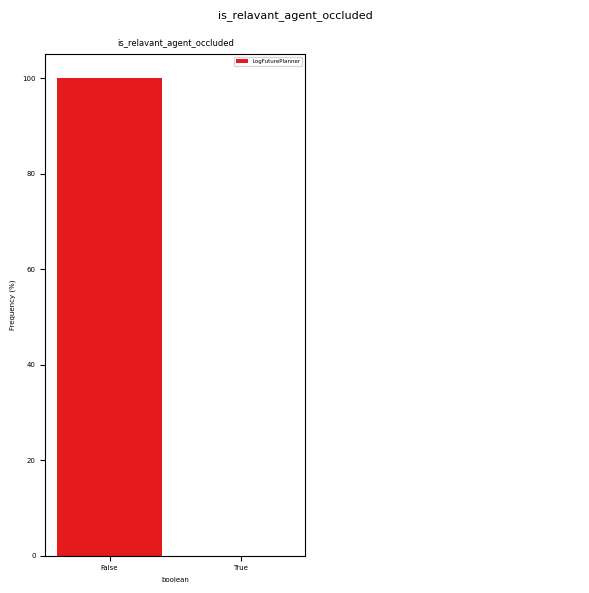

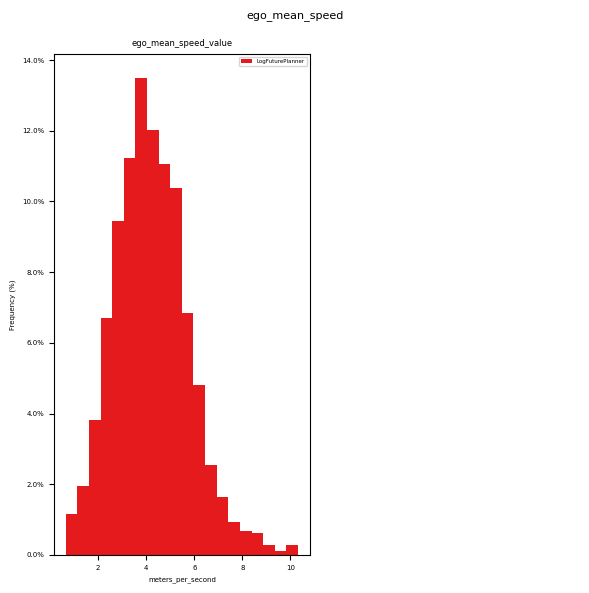

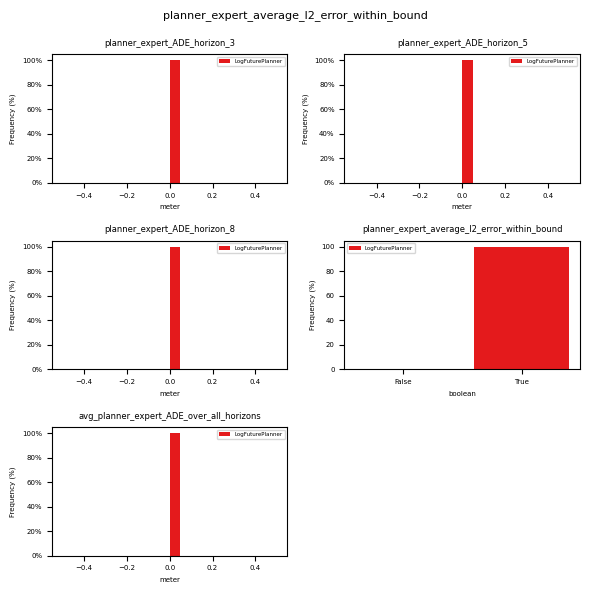

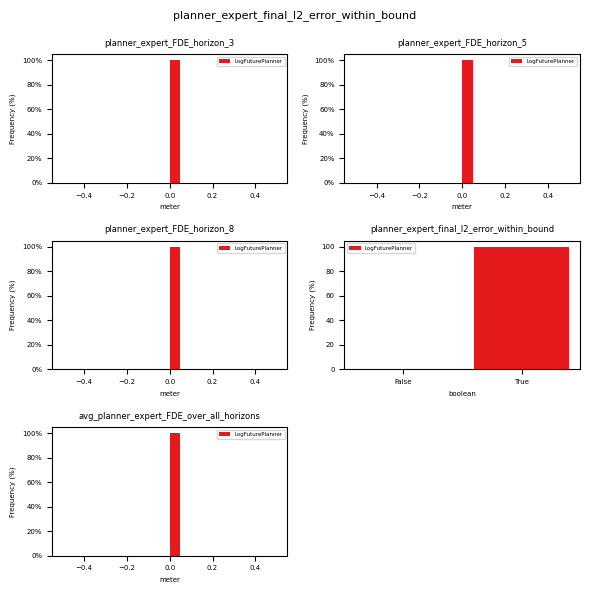

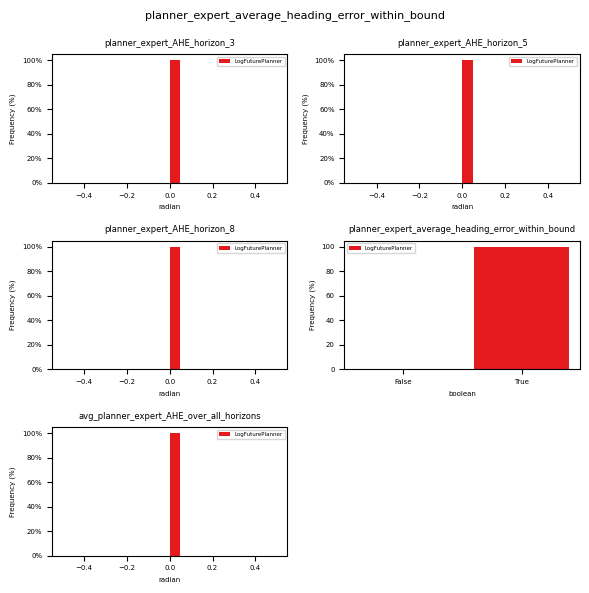

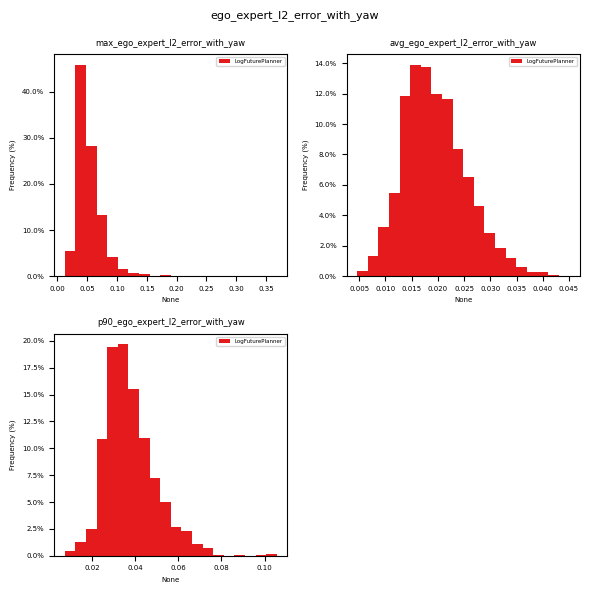

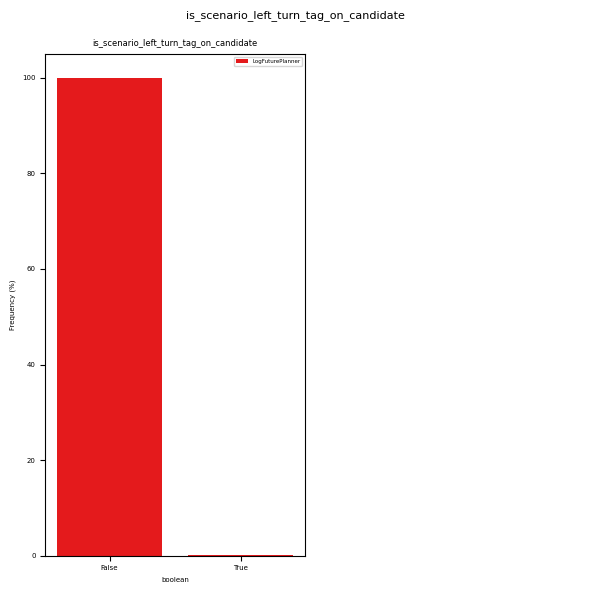

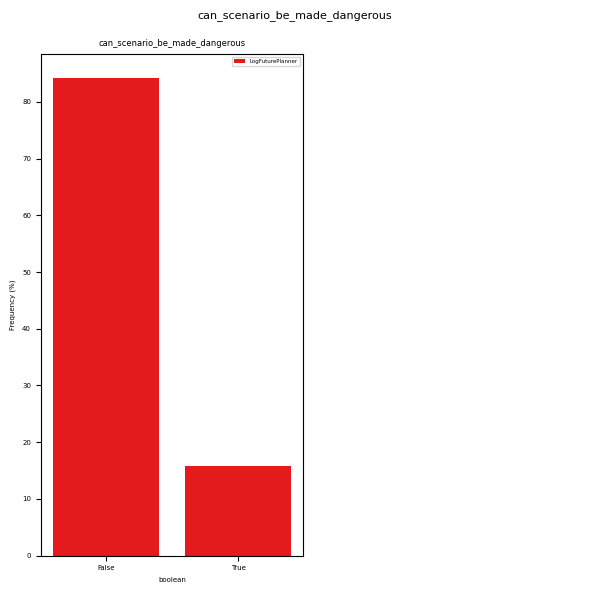

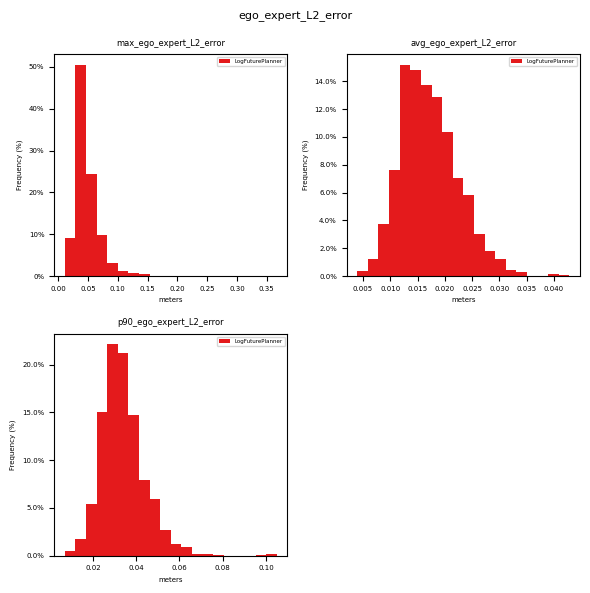

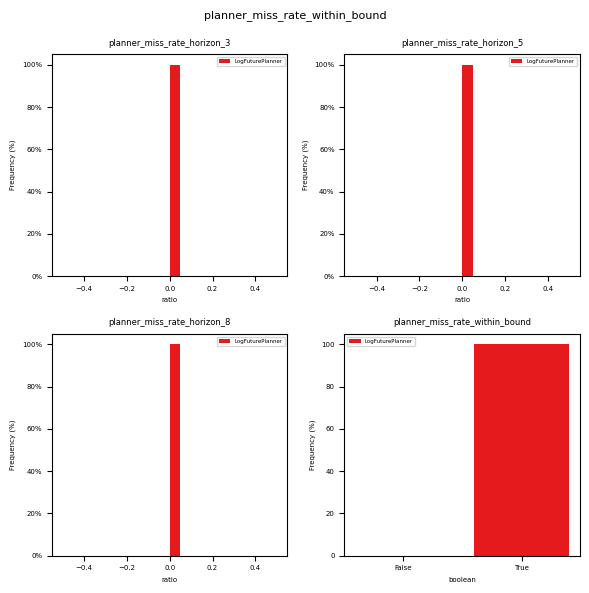

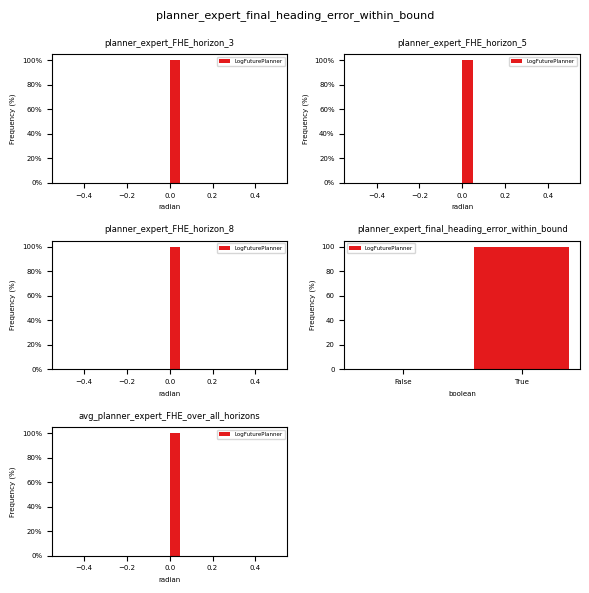

In [8]:
from nuplan.planning.script.run_simulation import main as main_simulation

# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg)

## Prepare the nuBoard config

In [9]:
output_folder_alt = []
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.21.59.48"
)
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.23.21.13"
)
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.07.32.41"
)
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_nonreactive_agents/2023.12.10.08.29.23"
)
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.11.00.41.30"
)
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.10.09.31.44"
)
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.12.21.28"
)
output_folder_alt.append(
    "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.13.13.07.48"
)

In [10]:
# scenario_builder = "val"  # [nuplan (uses trainval), nuplan_mini, test, val, train_boston, train_pittsburgh, train_singapore]
# output_folder = "../../data/nuplan/exp/exp/simulation/open_loop_boxes/2023.12.31.02.58.31"

# without injection
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.01.02.00.44.56"

# output_folder = (
#     "../../data/nuplan/exp/exp/simulation/open_loop_boxes/2023.12.20.13.59.34"
# )
# output_folder = '../../data/nuplan/exp/exp/simulation/open_loop_boxes/2023.12.09.21.19.06'
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_reactive_agents/2023.12.09.21.59.48"
# Location of path with all nuBoard configs

# scenario_builder = "val"
# output_folder = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.01.18.22.20.52"
# print(output_folder)
CONFIG_PATH = "../nuplan/planning/script/config/nuboard"
CONFIG_NAME = "default_nuboard"

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)

# Compose the configuration
cfg = hydra.compose(
    config_name=CONFIG_NAME,
    overrides=[
        f"scenario_builder={scenario_builder}",  # set the database (same as simulation) used to fetch data for visualization
        f"simulation_path={output_folder}",  # [output_folder, output_folder_alt] nuboard file path(s), if left empty the user can open the file inside nuBoard
    ],
)

## Launch nuBoard (open in new tab - recommended)

In [11]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

2024-01-31 22:13:26,132 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2024-01-31 22:13:26,150 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2024-01-31 22:13:26,151 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2024-01-31 22:13:26,151 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:85}  Async rendering is set to: True
2024-01-31 22:13:26,152 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/server.py:403}  Starting Bokeh server version 2.4.3 (running on Tornado 6.3.3)
2024-01-31 22:13:26,152 WARNING {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/util.py:145}  Host wildcard '*' will allow connections originating from multiple (or possib

INFO:tornado.access:200 GET / (127.0.0.1) 1046.22ms


2024-01-31 22:13:28,672 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  101 GET /ws (127.0.0.1) 0.53ms
2024-01-31 22:13:28,672 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:132}  WebSocket connection opened
2024-01-31 22:13:28,673 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:213}  ServerConnection created


INFO:tornado.access:101 GET /ws (127.0.0.1) 0.53ms


2024-01-31 22:13:30,362 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2024-01-31 22:13:31,054 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0199 seconds.
2024-01-31 22:13:31,148 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (127.0.0.1) 1300.23ms


INFO:tornado.access:200 GET / (127.0.0.1) 1300.23ms
Rendering a scenario: 100%|██████████| 1/1 [00:00<00:00, 46.93it/s]


2024-01-31 22:16:47,329 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 1.9058 seconds.
2024-01-31 22:16:53,844 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:575}  Frame deferred: 3
2024-01-31 22:16:54,151 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:902}  Processing render queue for frame 3


Rendering a scenario: 100%|██████████| 1/1 [00:00<00:00, 61.85it/s]


2024-01-31 22:17:30,406 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 2.0911 seconds.


Rendering a scenario: 100%|██████████| 1/1 [00:00<00:00, 17.62it/s]


2024-01-31 22:19:17,363 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 2.0652 seconds.


Rendering a scenario: 100%|██████████| 1/1 [00:00<00:00, 26.72it/s]


2024-01-31 22:20:01,441 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 1.9845 seconds.
